In [1]:
import pandas as pd
import numpy as np
import cvxopt
import seaborn as sns
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from cvxopt import matrix, solvers
from statsmodels.formula.api import logit
from scipy import optimize
from scipy.optimize import minimize
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Functions:
## 4(b),4(c)
def classifyVector(p):
    if p>0.5:return 1
    else: return 0

In [3]:
df_4=pd.read_csv('B8816-TakeHomeFinal-question4.csv')

In [4]:
### Null value
df_4.isnull().sum()/len(df_4)

srch_id                        0.000000
date_time                      0.000000
site_id                        0.000000
visitor_location_country_id    0.000000
visitor_hist_starrating        0.945845
visitor_hist_adr_usd           0.945705
prop_country_id                0.000000
prop_id                        0.000000
prop_starrating                0.000000
prop_review_score              0.001405
prop_brand_bool                0.000000
prop_location_score1           0.000000
prop_location_score2           0.217975
prop_log_historical_price      0.000000
position                       0.000000
price_usd                      0.000000
promotion_flag                 0.000000
srch_destination_id            0.000000
srch_length_of_stay            0.000000
srch_booking_window            0.000000
srch_adults_count              0.000000
srch_children_count            0.000000
srch_room_count                0.000000
srch_saturday_night_bool       0.000000
srch_query_affinity_score      0.936485


From the above, we can see that for the null value percentage, we can keep some low null value percentage features by dropping a few data. The features are the following:
'prop_review_score'

In [5]:
df_4=df_4[df_4['prop_review_score'].isnull()==False]

In [6]:
### unique search id
print(f"unique search id: {len(set(df_4['srch_id']))}")
### unique visitor_location_country id
print(f"unique visitor_location_country id: {len(df_4['visitor_location_country_id'].value_counts())}")
### unique prop id
print(f"unique prop id: {len(df_4['prop_id'].value_counts())}")
### unique prop_country id
print(f"unique prop_country id: {len(df_4['prop_country_id'].value_counts())}")
### number of click
print(f"number of click: {len(df_4[df_4['click_bool']==1])}")
### number of booking
print(f"number of booking: {len(df_4[df_4['booking_bool']==1])}")

unique search id: 8069
unique visitor_location_country id: 115
unique prop id: 58006
unique prop_country id: 117
number of click: 8942
number of booking: 5593


In [7]:
# prop_id corresponding to 
df_4['prop_id'].value_counts()

104517    112
124342    112
40279     109
59657     109
137997    109
         ... 
41636       1
80194       1
131365      1
49405       1
4094        1
Name: prop_id, Length: 58006, dtype: int64

In [8]:
# time span
df_4['date_time'].min(),df_4['date_time'].max()

('1/1/2013 11:49', '6/9/2013 9:34')

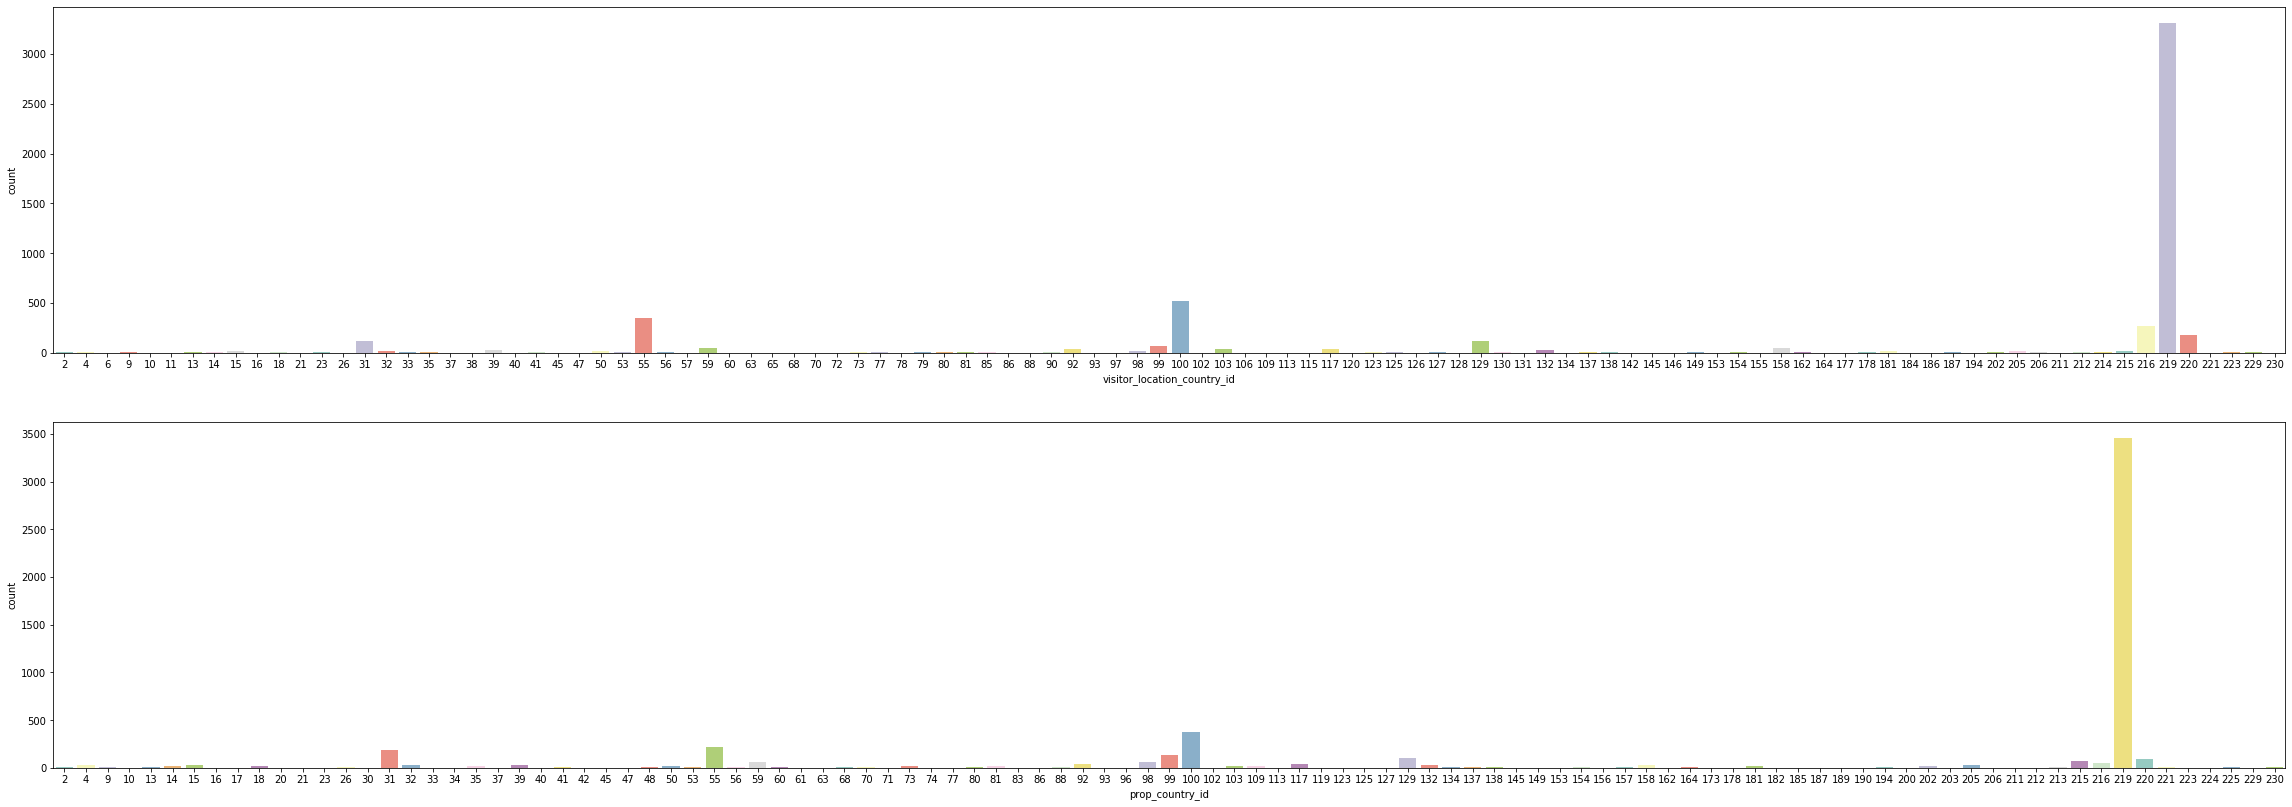

In [9]:
# Plot 
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(40,14))
bookings_df = df_4[df_4["booking_bool"] == 1]

# What are the most countries the customer travel from? - No.219 country
sns.countplot('visitor_location_country_id',data=bookings_df.sort_values(by=['visitor_location_country_id']),ax=axis1,palette="Set3")

# What are the most countries the customer travel to? - No.
sns.countplot('prop_country_id',data=bookings_df.sort_values(by=['prop_country_id']),ax=axis2,palette="Set3")


In [10]:
df_4['booking_bool'].value_counts()

0    194126
1      5593
Name: booking_bool, dtype: int64

In [11]:
# Convert srch_ci to Year, Month, and Week
df_4['Year']=df_4['date_time'].apply(lambda x: x.split(' ')[0].split('/')[2] if x == x else np.nan)
df_4['Month']=df_4['date_time'].apply(lambda x: x.split(' ')[0].split('/')[0] if x == x else np.nan)
df_4['day']=df_4['date_time'].apply(lambda x: x.split(' ')[0].split('/')[1] if x == x else np.nan)

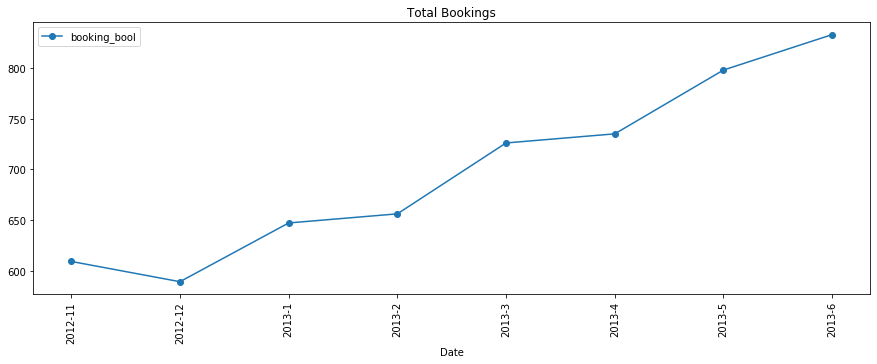

In [12]:
# Convert srch_ci column to Date(Y-M)
df_4['Date']  = df_4.apply(lambda x: f'{x.Year}-{x.Month}',axis=1)
# Plot number of bookings over Date
date_bookings  = df_4.groupby('Date')["booking_bool"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

### b

In [13]:
## Split the dataset
df = shuffle(df_4)
df_train = df[:round(0.8*len(df))]
df_test = df[round(0.8*len(df)):]
features_list = ['date_time','']

In [14]:
### Null value
df_4.isnull().sum()/len(df_4)

srch_id                        0.000000
date_time                      0.000000
site_id                        0.000000
visitor_location_country_id    0.000000
visitor_hist_starrating        0.945804
visitor_hist_adr_usd           0.945664
prop_country_id                0.000000
prop_id                        0.000000
prop_starrating                0.000000
prop_review_score              0.000000
prop_brand_bool                0.000000
prop_location_score1           0.000000
prop_location_score2           0.216875
prop_log_historical_price      0.000000
position                       0.000000
price_usd                      0.000000
promotion_flag                 0.000000
srch_destination_id            0.000000
srch_length_of_stay            0.000000
srch_booking_window            0.000000
srch_adults_count              0.000000
srch_children_count            0.000000
srch_room_count                0.000000
srch_saturday_night_bool       0.000000
srch_query_affinity_score      0.936396


In [15]:
df_4['comp1_rate_percent_diff'].value_counts().values

array([413, 411, 404, 377, 376, 325, 162,  90,  86,  80,  78,  71,  64,
        51,  51,  50,  50,  49,  42,  36,  29,  22,  19,  14,  14,  13,
        12,  11,  11,  11,  10,   9,   8,   8,   7,   7,   7,   6,   6,
         6,   5,   5,   5,   4,   4,   4,   4,   4,   3,   3,   3,   3,
         3,   3,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1])

In [16]:
#### Fill the nan value of competitor percentage rate data with median value of null values of that column
for column in ['comp1_rate_percent_diff','comp2_rate_percent_diff','comp3_rate_percent_diff',\
                  'comp4_rate_percent_diff','comp5_rate_percent_diff','comp6_rate_percent_diff',\
                  'comp7_rate_percent_diff','comp8_rate_percent_diff']:
    med_val = np.median(df_4[df_4[column].notnull()][column].values)
    df_4[column].fillna(med_val, inplace=True)

In [17]:
df_4.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

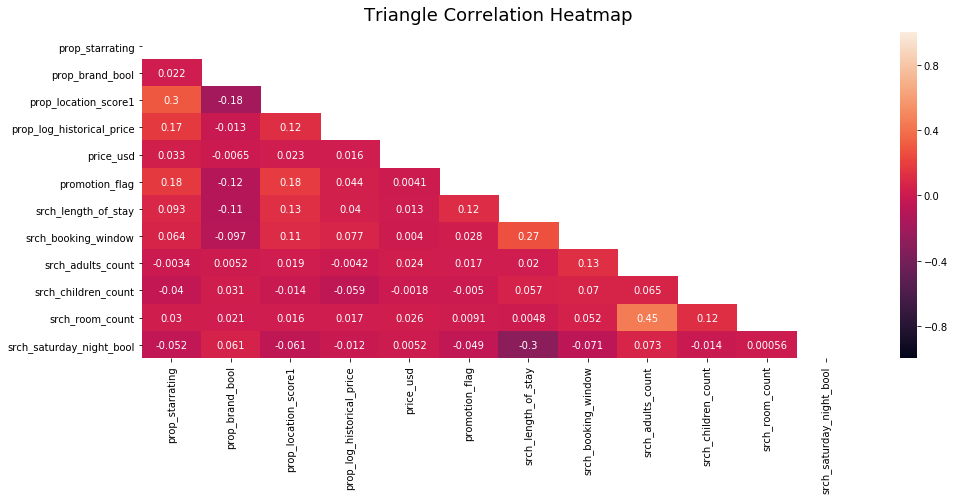

In [18]:
df_=df[['prop_starrating','prop_brand_bool','prop_location_score1','prop_log_historical_price',\
'price_usd','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count',\
'srch_room_count','srch_saturday_night_bool']]
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Based on the result above, there srch_room_count has a realtively strong relation ship with srch_adults_count. I decide to drop srch_adults_count column

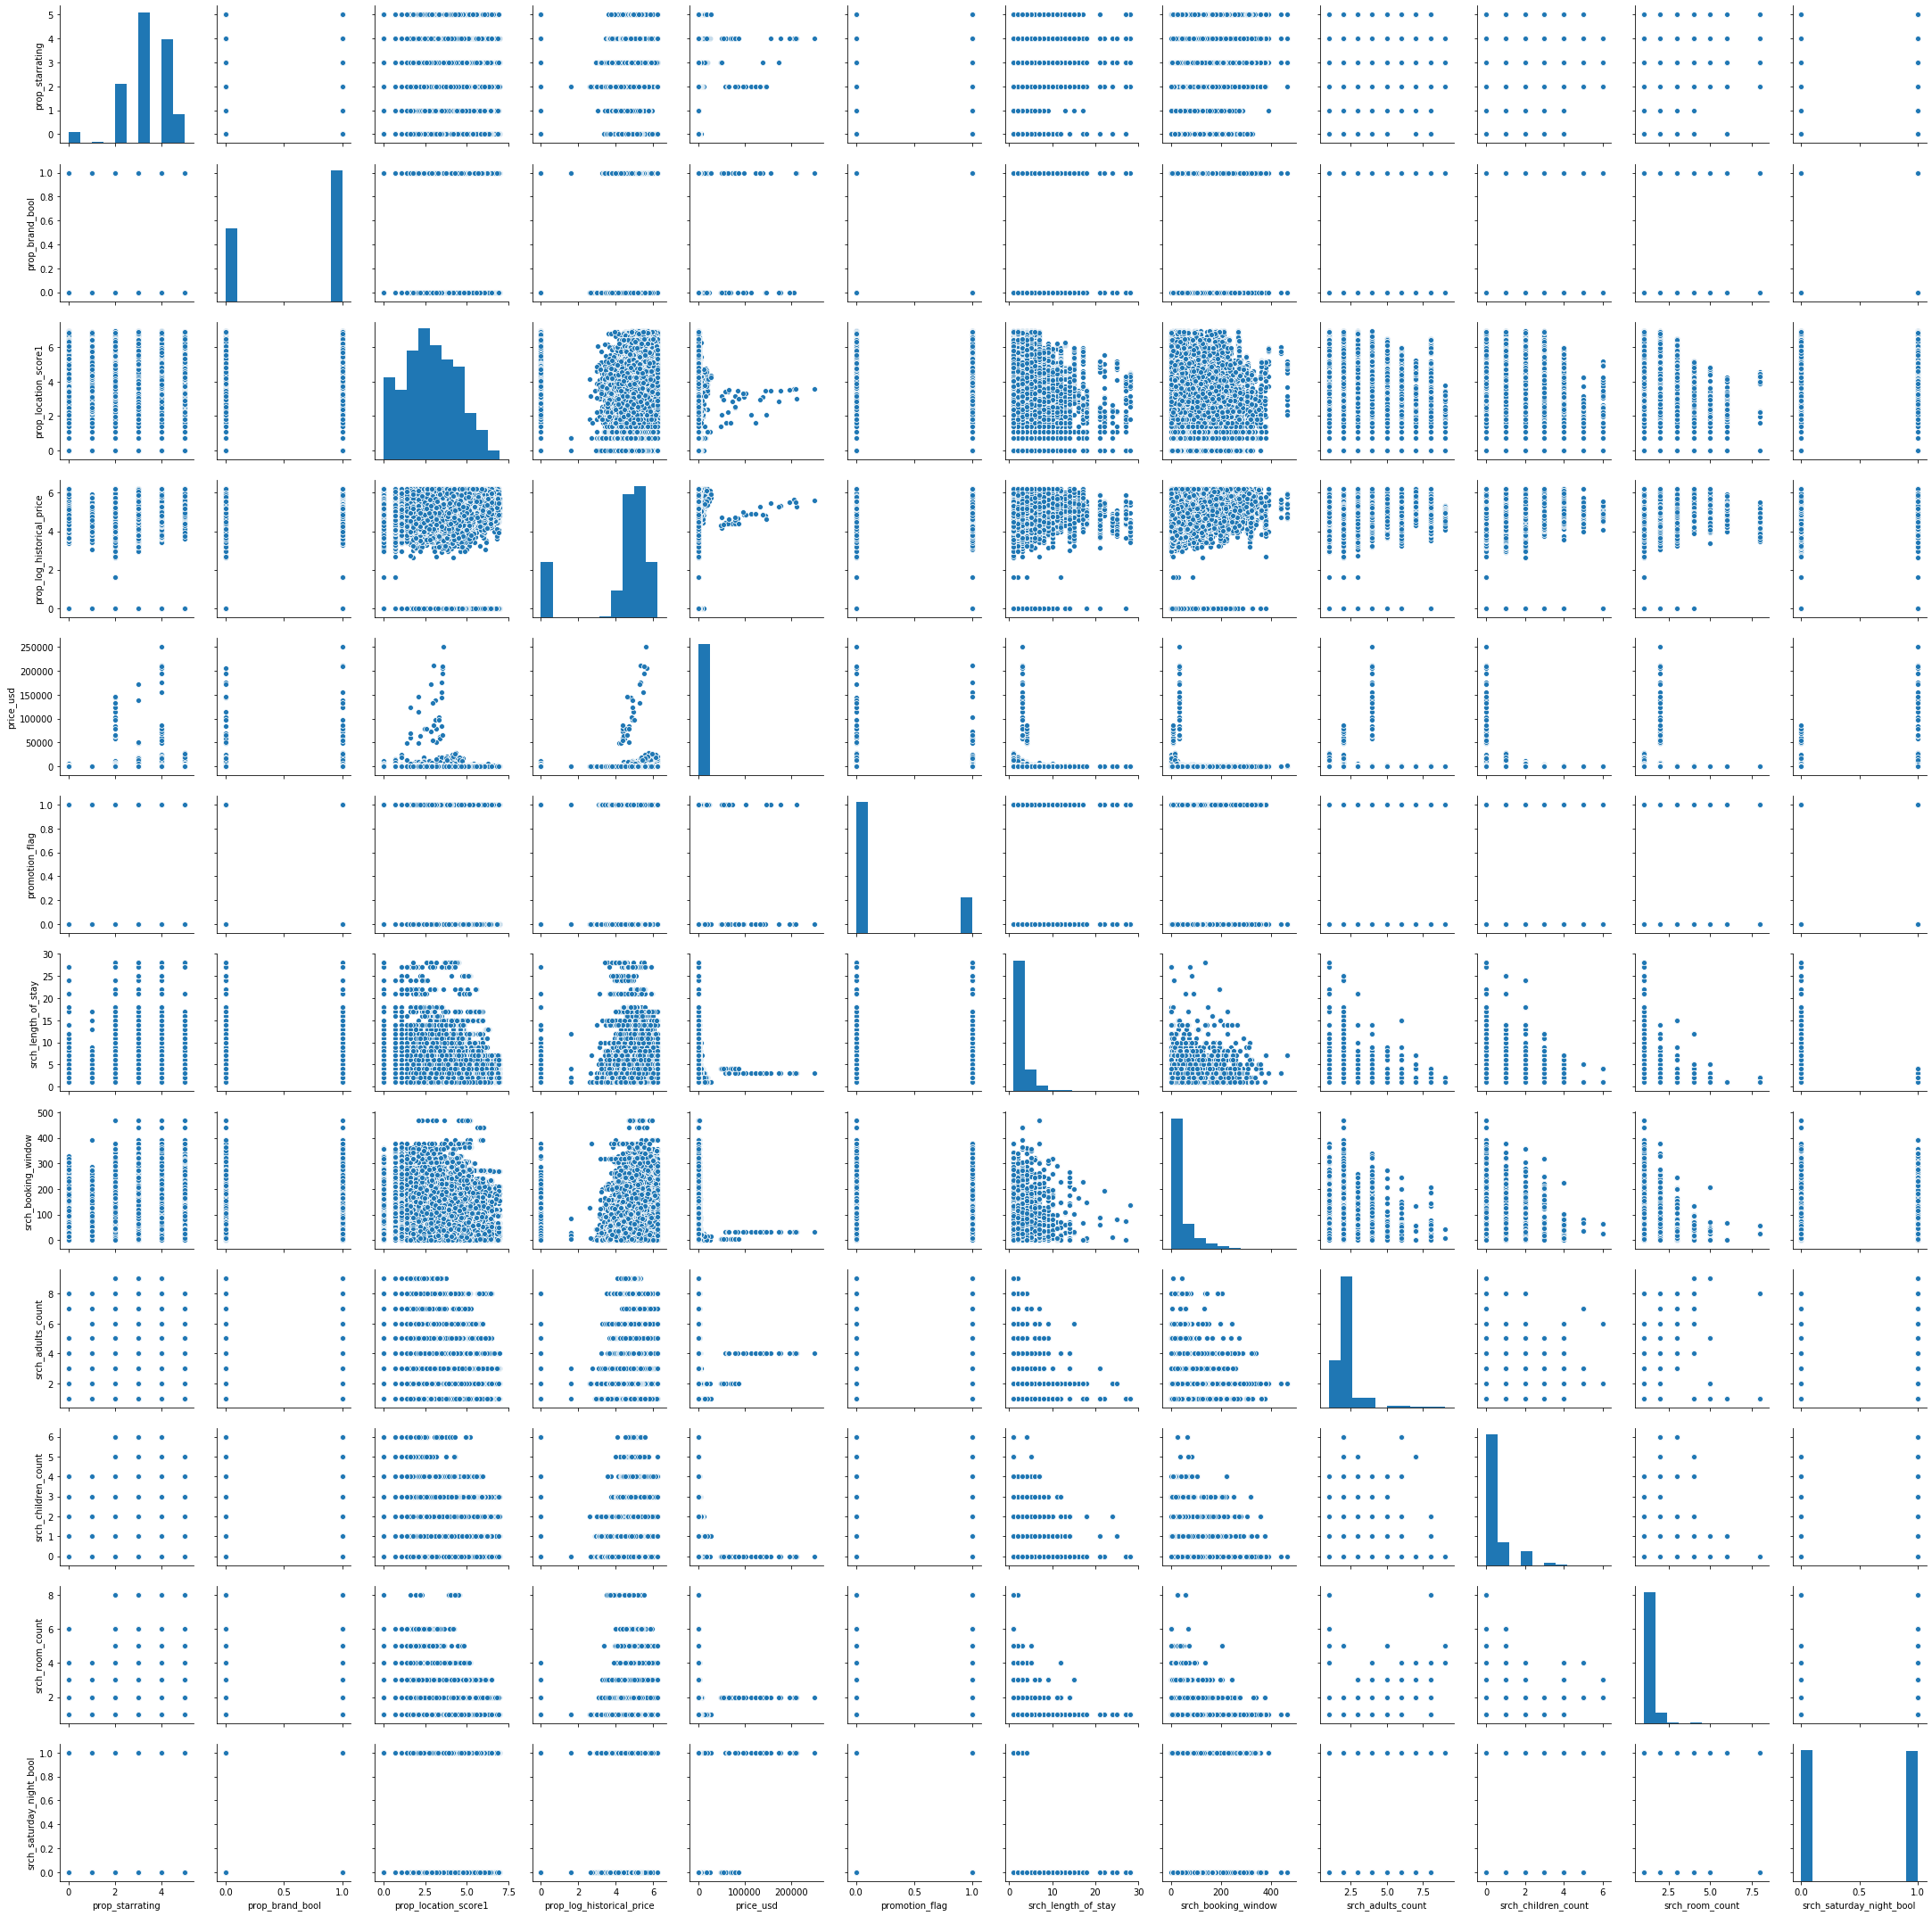

In [19]:
sns.pairplot(df_)

Based on the above distribution and correlation plot, we can see that some features- src_length_of_stay, srch_booking_window, and srch_room_count are right skewed. So we choose to take log transformation on those features.

## Baseline model with all variables

In [20]:
logit_model=logit("click_bool~prop_starrating+prop_brand_bool+prop_location_score1+np.exp(prop_log_historical_price)+\
price_usd+promotion_flag+srch_length_of_stay+np.log(srch_booking_window+1e-6)+srch_children_count+\
np.log(srch_room_count+1e-6)+srch_saturday_night_bool+prop_review_score",df_train).fit()
print(logit_model.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Optimization terminated successfully.
         Current function value: 0.182361
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             click_bool   No. Observations:               159775
Model:                          Logit   Df Residuals:                   159762
Method:                           MLE   Df Model:                           12
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                0.006849
Time:                        15:57:19   Log-Likelihood:                -29137.
converged:                       True   LL-Null:                       -29338.
Covariance Type:            nonrobust   LLR p-value:                 1.504e-78
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -3.7702      0.065    

In [ ]:
import statsmodels.formula.api as smf
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = logit(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


model = forward_selected(df_train, 'click_bool')

print(model.model.formula)
# sl ~ rk + yr + 1

print(model.rsquared_adj)
# 0.835190760538

## Stepwise feature selection

In [26]:
candidate_variables=np.array(['prop_starrating','prop_brand_bool','prop_location_score1',\
                              'np.exp(prop_log_historical_price)','price_usd',\
                              'srch_length_of_stay','np.log(srch_booking_window+1e-6)','srch_children_count',\
                              'np.log(srch_room_count+1e-6)','srch_saturday_night_bool','prop_review_score'])


def classifyVector(p):
    if p>0.5:return 1
    else: return 0

full=len(candidate_variables)
best_model="click_bool~promotion_flag"
BEST_acc=np.inf
y_true=df_train['click_bool']
#store accuracy of each model
acc_list=[]

for i in np.arange(full-1,-1,-1):
    
    acc_list=np.empty(i+1)
    
    for j in range(i+1):
        candidate_formula=best_model+"+"+candidate_variables[j]
        y_prob=logit(formula=candidate_formula,data=df_train).fit().predict(df_train)
        y_pred=y_prob.apply(lambda x: classifyVector(x))
        acc_list[j]=np.sum(y_pred==y_true)/len(y_true)
    
    print(acc_list)
    
    if BEST_acc>np.min(acc_list):
        Add_i=np.where(acc_list==np.min(acc_list))[0][0]
        best_model=best_model+"+"+candidate_variables[Add_i]
        #print(Add_i)
        print("variable added:", candidate_variables[Add_i])
        # print(best_model)
        BEST_acc=np.min(acc_list)
        candidate_variables=np.delete(candidate_variables,Add_i)    
    else:
        break

best_model

Optimization terminated successfully.
         Current function value: 0.181721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181958
  

'click_bool~promotion_flag+prop_starrating'

## 4(b) Final Model

In [21]:
logit_model=logit("click_bool~prop_starrating+prop_location_score1+\
np.exp(prop_log_historical_price)+promotion_flag+srch_children_count\
+position+np.log(srch_room_count+1e-6)+srch_saturday_night_bool+prop_review_score",df_train).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.168032
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             click_bool   No. Observations:               159775
Model:                          Logit   Df Residuals:                   159765
Method:                           MLE   Df Model:                            9
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                 0.08489
Time:                        15:57:20   Log-Likelihood:                -26847.
converged:                       True   LL-Null:                       -29338.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -2.2228      0.066    -33

In [22]:
### Trainning set
y_prob=logit_model.predict(df_train)
y_pred=y_prob.apply(lambda x: classifyVector(x))
y_true=df_train['click_bool']
print('Model trainning set accuracy',np.sum(y_pred==y_true)/len(y_true))
## Testing set
y_prob=logit_model.predict(df_test)
y_pred=y_prob.apply(lambda x: classifyVector(x))
y_true=df_test['click_bool']
print('Model testing set accuracy',np.sum(y_pred==y_true)/len(y_true))

Model trainning set accuracy 0.9549679236426224
Model testing set accuracy 0.9562637692769878


### c

In [23]:
df_train1=df_train[df_train['click_bool']==1]
logit_model1=logit("booking_bool~prop_starrating+prop_brand_bool+prop_location_score1+np.exp(prop_log_historical_price)+\
price_usd+promotion_flag+np.log(srch_length_of_stay+1e-6)+np.log(srch_booking_window+1e-6)\
+position+srch_children_count+np.log(srch_room_count+1e-6)+srch_saturday_night_bool+prop_review_score+random_bool",df_train1).fit()
print(logit_model1.summary())


Optimization terminated successfully.
         Current function value: 0.367067
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           booking_bool   No. Observations:                 7195
Model:                          Logit   Df Residuals:                     7180
Method:                           MLE   Df Model:                           14
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.4455
Time:                        15:57:20   Log-Likelihood:                -2641.0
converged:                       True   LL-Null:                       -4762.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              2.1580      0.208    

Based on the model above, features prop_location_score1, price_usd, srch_children_count are not significant in the model.

### 4(c) Final Logistic Model

In [24]:
logit_model1=logit("booking_bool~prop_brand_bool+np.exp(prop_log_historical_price)+\
promotion_flag+position+np.log(srch_length_of_stay+1e-6)+np.log(srch_booking_window+1e-6)\
+srch_adults_count+np.log(srch_room_count+1e-6)+srch_saturday_night_bool+prop_review_score+random_bool\
",df_train1).fit()
print(logit_model1.summary())

Optimization terminated successfully.
         Current function value: 0.367148
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           booking_bool   No. Observations:                 7195
Model:                          Logit   Df Residuals:                     7183
Method:                           MLE   Df Model:                           11
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.4454
Time:                        15:57:20   Log-Likelihood:                -2641.6
converged:                       True   LL-Null:                       -4762.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              2.2266      0.202    

In [25]:
## Training set
y_prob1=logit_model1.predict(df_train1)
y_pred1=y_prob1.apply(lambda x: classifyVector(x))
y_true1=df_train1['booking_bool']
print('Model trainning set accuracy',np.sum(y_pred1==y_true1)/len(y_true1))
## Testing set
df_test1=df_test[df_test['click_bool']==1]
y_prob1=logit_model1.predict(df_test1)
y_pred1=y_prob1.apply(lambda x: classifyVector(x))
y_true1=df_test1['booking_bool']
print('Model testing set accuracy',np.sum(y_pred1==y_true1)/len(y_true1))

Model trainning set accuracy 0.8722724113968033
Model testing set accuracy 0.859187178019462


### Tree-based model

In [26]:
#continuous outcome
from sklearn.tree import DecisionTreeRegressor
#categorial outcome

df_train.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

In [27]:
## fill null value of visitor history starrating to 0
df_train['visitor_hist_starrating']=df_train['visitor_hist_starrating'].fillna(value=0)
df_test['visitor_hist_starrating']=df_test['visitor_hist_starrating'].fillna(value=0)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df_train2=df_train[['visitor_hist_starrating','prop_starrating','prop_review_score',\
                   'prop_brand_bool','prop_location_score1','prop_log_historical_price',\
                   'position','price_usd','promotion_flag','srch_length_of_stay','srch_booking_window',\
                   'srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool',\
                   'random_bool','click_bool','booking_bool']]

df_train2=df_train2[df_train2['click_bool']==1]

df_test2=df_test[['visitor_hist_starrating','prop_starrating','prop_review_score',\
                   'prop_brand_bool','prop_location_score1','prop_log_historical_price',\
                   'position','price_usd','promotion_flag','srch_length_of_stay','srch_booking_window',\
                   'srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool',\
                   'random_bool','click_bool','booking_bool']]

df_test2=df_test2[df_test2['click_bool']==1]

## Final Decision Tree Model

In [36]:
df_train2

,visitor_hist_starrating,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_log_historical_price,position,price_usd,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,random_bool,click_bool,booking_bool
17204,0.0,4,4.0,1,1.61,4.93,15,143.00,0,1,11,2,0,1,0,0,1,0
25029,0.0,4,5.0,1,5.96,4.84,25,146.74,0,1,52,2,0,1,0,0,1,0
30396,0.0,3,3.5,0,1.95,4.59,10,68.00,1,1,1,1,0,1,0,1,1,0
148910,0.0,4,4.0,0,1.10,5.14,1,101.85,0,1,1,1,0,1,1,0,1,1
139952,0.0,4,4.5,0,2.48,5.47,21,160.00,0,5,72,2,2,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,0.0,3,3.5,1,0.69,4.93,3,116.00,0,6,185,2,2,1,0,0,1,1
150656,0.0,3,4.5,1,2.56,4.95,3,99.00,0,1,20,4,0,1,1,0,1,1
179226,0.0,3,4.0,1,2.20,5.07,8,114.00,0,1,0,2,0,1,1,0,1,1
39744,0.0,4,5.0,1,3.00,5.41,1,412.14,0,1,14,2,0,1,0,0,1,1


In [37]:
### Model fit and training
model=DecisionTreeRegressor(max_depth=4)
model.fit(df_train2.iloc[:,:-2],df_train2.iloc[:,-1])

## Model accuracy
## Training set
y_prob2=pd.Series(model.predict(df_train2.iloc[:,:-2]))
y_pred2=y_prob2.apply(lambda x: classifyVector(x))
y_true2=df_train2.iloc[:,-1].values
print('Model trainning set accuracy',np.sum(y_pred2==y_true2)/len(y_true2))

## Testing set
y_prob2=pd.Series(model.predict(df_test2.iloc[:,:-2]))
y_pred2=y_prob2.apply(lambda x: classifyVector(x))
y_true2=df_test2.iloc[:,-1].values
print('Model testing set accuracy',np.sum(y_pred2==y_true2)/len(y_true2))

Model trainning set accuracy 0.8740792216817235
Model testing set accuracy 0.859187178019462


In [38]:
# GridSearchCV hyper-parameter tuning
param = [{'criterion':['gini'],'max_depth':[5,10,15,20,25,30,35],'min_samples_leaf':[2,3,5,10],'min_impurity_decrease':[0.1,0.2,0.5]},
         {'criterion':['gini','entropy']},
         {'max_depth': [30,60,100], 'min_impurity_decrease':[0.1,0.2,0.5]}]
grid = GridSearchCV(DecisionTreeClassifier(),param_grid=param,cv=6)
grid.fit(df_train2.iloc[:,:-2],df_train2.iloc[:,-1])
print('The best classifier:',grid.best_params_,'Best score:', grid.best_score_)

The best classifier: {'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2} Best score: 0.8724113968033357


In [39]:
clf = DecisionTreeClassifier(max_depth=5,min_samples_leaf=35,min_impurity_decrease=0.1)
clf.fit(df_train2.iloc[:,:-2],df_train2.iloc[:,-1])
y_pred = clf.predict(df_test2.iloc[:,:-2])
print('Training score：', clf.score(df_train2.iloc[:,:-2],df_train2.iloc[:,-1]),'testing score',clf.score(df_train2.iloc[:,:-2],df_train2.iloc[:,-1]))


Training score： 0.8724113968033357 testing score 0.8724113968033357


## Final Random Forest Model

In [40]:
model=RandomForestRegressor(n_estimators=1000,max_features=15,max_depth=25)
model.fit(df_train2.iloc[:,:-2],df_train2.iloc[:,-1])
## Model accuracy
## Training set
y_prob2=pd.Series(model.predict(df_train2.iloc[:,:-2]))
y_pred2=y_prob2.apply(lambda x: classifyVector(x))
y_true2=df_train2.iloc[:,-1].values
print('Model trainning set accuracy',np.sum(y_pred2==y_true2)/len(y_true2))
## Testing set
y_prob2=pd.Series(model.predict(df_test2.iloc[:,:-2]))
y_pred2=y_prob2.apply(lambda x: classifyVector(x))
y_true2=df_test2.iloc[:,-1].values
print('Model testing set accuracy',np.sum(y_pred2==y_true2)/len(y_true2))

Model trainning set accuracy 1.0
Model testing set accuracy 0.859187178019462


In [41]:
# GridSearchCV hyper-parameter tuning
param = [{"n_estimators":[1800,2200],'max_features':[8,14],'max_depth':[15,25]}]
grid = GridSearchCV(RandomForestRegressor(),param_grid=param,cv=6)
grid.fit(df_train2.iloc[:,:-2],df_train2.iloc[:,-1])
print('The best classifier:',grid.best_params_,'Best score:', grid.best_score_)

The best classifier: {'max_depth': 15, 'max_features': 8, 'n_estimators': 2200} Best score: 0.5384724971866754
